In [1]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from IPython.display import clear_output
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import pandas as pd
import torchvision
import numpy as np
import torch
import time

# Importing and Transforming The Data 


In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),            
    transforms.ToTensor(),                   
    transforms.Normalize((0.5, 0.5, 0.5),    
                         (0.5, 0.5, 0.5)),
    transforms.RandomAffine(degrees=0, translate=(0.12, 0.12), scale=(0.9, 1.1), shear=10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=[0.9, 1.1])
])

batch_size = 64

train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                             train=True,
                                             transform=transform,
                                             download=True)



test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                            train=False,
                                            transform=transform,
                                            download=True)


num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)


100%|██████████| 170498071/170498071 [00:04<00:00, 40248946.45it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Number of classes: 10


In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the labels of the CIFAR-10 dataset
labels = train_dataset.targets

# Use StratifiedShuffleSplit to split the dataset into train and validation sets
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Get the indices for the train and validation sets
train_idx, val_idx = next(sss.split(labels, labels))

# Create Subset objects using the indices
train_subset = torch.utils.data.Subset(train_dataset, train_idx)
val_subset = torch.utils.data.Subset(train_dataset, val_idx)

# Get the labels for train_subset and val_subset
train_labels = [train_dataset.targets[idx] for idx in train_idx]
val_labels = [train_dataset.targets[idx] for idx in val_idx]

# Count the occurrences of each label in train_subset and val_subset
train_label_counts = np.bincount(train_labels, minlength=10)
val_label_counts = np.bincount(val_labels, minlength=10)

# Print the distribution of labels in train_subset
print("Label distribution in train_subset:")
for i, count in enumerate(train_label_counts):
    print(f"Label {i}: {count} samples")

# Print the distribution of labels in val_subset
print("\nLabel distribution in val_subset:")
for i, count in enumerate(val_label_counts):
    print(f"Label {i}: {count} samples")
    
trainloader = torch.utils.data.DataLoader(train_subset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=2)

validloader = torch.utils.data.DataLoader(val_subset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=2)

Label distribution in train_subset:
Label 0: 4000 samples
Label 1: 4000 samples
Label 2: 4000 samples
Label 3: 4000 samples
Label 4: 4000 samples
Label 5: 4000 samples
Label 6: 4000 samples
Label 7: 4000 samples
Label 8: 4000 samples
Label 9: 4000 samples

Label distribution in val_subset:
Label 0: 1000 samples
Label 1: 1000 samples
Label 2: 1000 samples
Label 3: 1000 samples
Label 4: 1000 samples
Label 5: 1000 samples
Label 6: 1000 samples
Label 7: 1000 samples
Label 8: 1000 samples
Label 9: 1000 samples


# Data Visualization 

## Normlized vs non-normlized

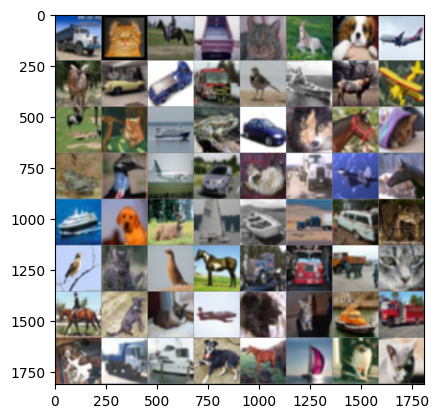

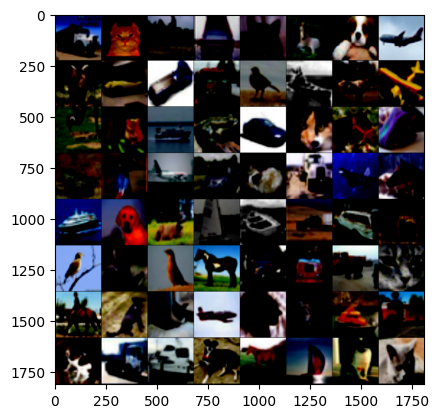

torch.Size([3, 224, 224])


In [4]:
def imshow(img, un):
    if(un):
        img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images), True)
imshow(torchvision.utils.make_grid(images), False)
print(images[0].shape)

## Class Distribution

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


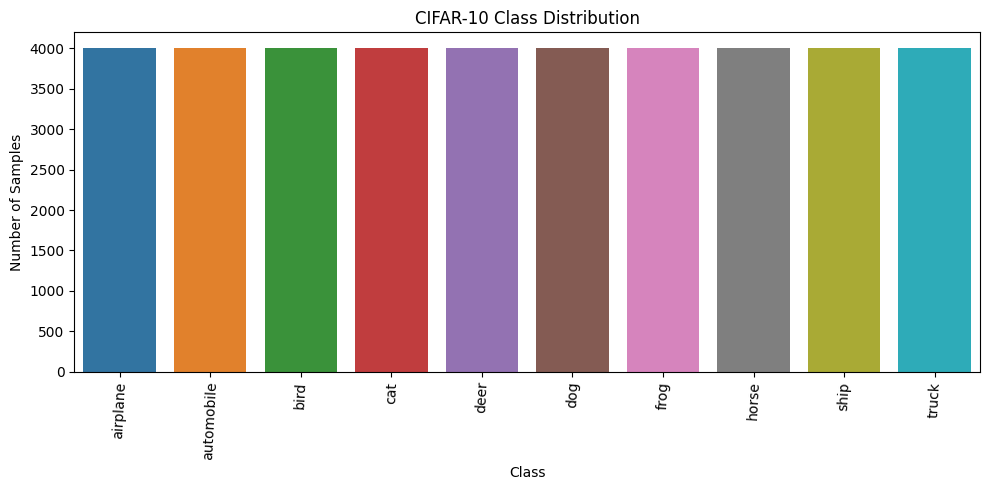

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

class_counts = np.zeros(num_classes, dtype=int)
for _, labels in trainloader:
    for label in labels:
        class_counts[label] += 1

plt.figure(figsize=(10, 5))
sns.barplot(x=train_dataset.classes, y=class_counts)
plt.xticks(rotation=87)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('CIFAR-10 Class Distribution')
plt.tight_layout()
plt.show()

# Model Architecture 

## Downloading pretrained model

### RESNET-50 Pretrained

In [6]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


In [7]:
model_setup_res50 = models.resnet50(pretrained=True)

model_setup_res50 = model_setup_res50.cuda() if use_cuda else model
    
num_ftrs = model_setup_res50.fc.in_features
model_setup_res50.fc = torch.nn.Linear(num_ftrs, 1024)
model_setup_res50.fc = nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(num_ftrs, 1024),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(1024, 512),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(512, 256),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 128),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(128, len(train_dataset.classes))
)

model_setup_res50.fc = model_setup_res50.fc.cuda() if use_cuda else model.fc

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s]


### EfficientNet_B0 Pretrained

In [8]:
import torch.nn as nn
import torchvision.models as models

model_setup_effb50 = models.efficientnet_b0(pretrained=True)
model_setup_effb50.classifier = nn.Linear(1280, 100)

# Determine the total number of layers in the model
total_layers = len(list(model_setup_effb50.children()))

num_layers_to_freeze = total_layers // 2

frozen_layers = 0

for name, param in model_setup_effb50.named_parameters():
    if frozen_layers < num_layers_to_freeze:
        param.requires_grad = False
        frozen_layers += 1
    else:
        break  



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 84.3MB/s]


# Defining The Train Function 


In [9]:
def train(model, dataloader, loss_fn, optimizer, device, length_dataloader, length_dataset):
    model.train()
    total_loss = 0

    total_correct = 0
    for batch in tqdm(dataloader):
        inputs, labels = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        predictions = outputs.argmax(dim=1)

        correct = (predictions == labels).sum().item()
        total_correct += correct

    return total_loss / length_dataloader, total_correct / length_dataset

# Accuracy Function 


In [10]:
def compute_accuracy(dataloader, model):
    model.eval()

    total_correct = 0
    total_count = 0
    with torch.no_grad():
        for batch in tqdm(dataloader):
            inputs, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(inputs)
            predictions = outputs.argmax(dim=1)
            correct = (predictions == labels).sum().item()
            total_correct += correct
            total_count += len(labels)

    accuracy = total_correct / total_count
    return accuracy

# Model Initialization & Configuration 


In [11]:
class LogSoftmaxNLLLoss(nn.Module):
    def __init__(self):
        super(LogSoftmaxNLLLoss, self).__init__()
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.nll_loss = nn.NLLLoss()

    def forward(self, input, target):
        log_probs = self.log_softmax(input)
        return self.nll_loss(log_probs, target)

In [12]:
loss_fn = LogSoftmaxNLLLoss()

# Main Training Loop 


### RESNET-50 Training and Evaluation

In [13]:
model_resnet = model_setup_res50
length_dataloader = len(trainloader)

bestScore = 0
patience = 15
num_epochs = 30
best_epoch = 0

optimizer = optim.SGD(model_resnet.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

if(torch.cuda.is_available()):
    device = torch.device('cuda')
elif(torch.backends.mps.is_available()):
    device = torch.device('mps')
else:
    device = torch.device('cpu')

model_resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Epoch 30/30, Train Loss: 0.0012, lr: 0.0001000
Cross Acc: 0.9594, Train Acc: 0.9999
Patience REM :  4


100%|██████████| 157/157 [00:18<00:00,  8.57it/s]


Test Acc: 0.9594


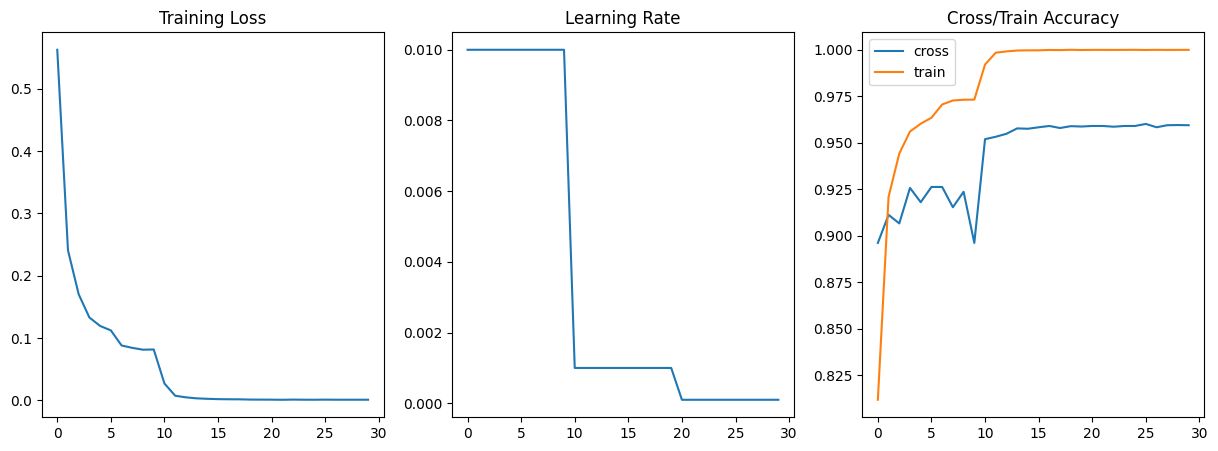

In [14]:
train_losses = []
cross_accs = []
train_accs = []
lr = []
print('RESNET-50 Training Loop\n')
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_resnet, trainloader, loss_fn, optimizer, device, length_dataloader, length_dataloader*batch_size)
    CurrentScore = compute_accuracy(validloader, model_resnet)

    lr.append(optimizer.param_groups[0]['lr'])
    train_losses.append(train_loss)
    cross_accs.append(CurrentScore)
    train_accs.append(train_acc)
    clear_output(wait=True)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, lr: {lr[-1]:.7f}')
    print(f'Cross Acc: {CurrentScore:.4f}, Train Acc: {train_acc:.4f}')
    scheduler.step()

    
    print("Patience REM : ", epoch - best_epoch)
    if CurrentScore > bestScore:
        bestScore = CurrentScore
        best_epoch = epoch
        torch.save(model_resnet.state_dict(), '/kaggle/working/best_model_resnet_5O.pth')
    elif epoch - best_epoch >= patience:
        print(f'Validation loss did not improve for {patience} epochs. Training stopped.')
        break
        
FinalScore = compute_accuracy(testloader, model_resnet)
print(f'Test Acc: {CurrentScore:.4f}')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(train_losses)
axs[0].set_title('Training Loss')
axs[1].plot(lr)
axs[1].set_title('Learning Rate')
axs[2].plot(cross_accs, label="cross")
axs[2].plot(train_accs, label = "train")
axs[2].set_title('Cross/Train Accuracy')
axs[2].legend()
plt.show(block=False)

### EfficientNet_B0 Training and Evaluation

In [15]:
model_effb50 = model_setup_effb50
length_dataloader = len(trainloader)

bestScore = 0
patience = 15
num_epochs = 30
best_epoch = 0

optimizer = optim.SGD(model_effb50.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

if(torch.cuda.is_available()):
    device = torch.device('cuda')
elif(torch.backends.mps.is_available()):
    device = torch.device('mps')
else:
    device = torch.device('cpu')

model_effb50.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Epoch 30/30, Train Loss: 0.0023, lr: 0.0000274
Cross Acc: 0.9743, Train Acc: 0.9994
Patience REM :  8


100%|██████████| 157/157 [00:11<00:00, 13.17it/s]


Test Acc: 0.9743


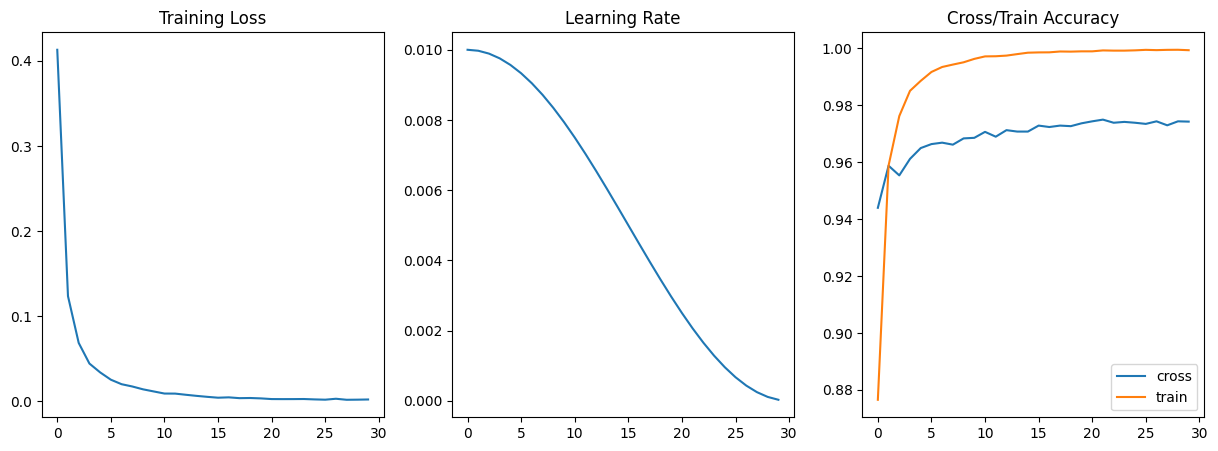

In [16]:
train_losses = []
cross_accs = []
train_accs = []
lr = []
print('EfficientNet-B50 Training Loop\n')
for epoch in range(num_epochs):
    train_loss, train_acc = train(model_effb50, trainloader, loss_fn, optimizer, device, length_dataloader, length_dataloader*batch_size)
    CurrentScore = compute_accuracy(validloader, model_effb50)

    lr.append(optimizer.param_groups[0]['lr'])
    train_losses.append(train_loss)
    cross_accs.append(CurrentScore)
    train_accs.append(train_acc)
    clear_output(wait=True)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, lr: {lr[-1]:.7f}')
    print(f'Cross Acc: {CurrentScore:.4f}, Train Acc: {train_acc:.4f}')
    scheduler.step()

    
    print("Patience REM : ", epoch - best_epoch)
    if CurrentScore > bestScore:
        bestScore = CurrentScore
        best_epoch = epoch
        torch.save(model_effb50.state_dict(), '/kaggle/working/best_model_efficient_netb5O.pth')
    elif epoch - best_epoch >= patience:
        print(f'Validation loss did not improve for {patience} epochs. Training stopped.')
        break
        
FinalScore = compute_accuracy(testloader, model_effb50)
print(f'Test Acc: {CurrentScore:.4f}')

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(train_losses)
axs[0].set_title('Training Loss')
axs[1].plot(lr)
axs[1].set_title('Learning Rate')
axs[2].plot(cross_accs, label="cross")
axs[2].plot(train_accs, label = "train")
axs[2].set_title('Cross/Train Accuracy')
axs[2].legend()
plt.show(block=False)

# Loading Back The Best Model 



In [17]:
model_resnet.load_state_dict(torch.load('/kaggle/working/best_model_resnet_5O.pth', map_location=device))

<All keys matched successfully>

In [18]:
model_effb50.load_state_dict(torch.load('/kaggle/working/best_model_efficient_netb5O.pth', map_location=device))

<All keys matched successfully>

# Getting model Predictions 

In [19]:
def getPreds(dataloader, model):
    preds = []
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch[0].to(device)
            outputs = model(inputs)
            predictions = outputs.argmax(dim=1)
            preds.extend(predictions.cpu().numpy())

    return preds

# Inference Time 

In [20]:
import time

infloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2) ## create a dummy datalaoder with batchsize = 1
img, _ = next(iter(infloader))
img = img.to(device)
start = time.time() ## record start time
_ = model_resnet(img)
end = time.time() ## records end time

print(end - start)

0.06244039535522461


In [21]:
import time

infloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2) ## create a dummy datalaoder with batchsize = 1
img, _ = next(iter(infloader))
img = img.to(device)
start = time.time() ## record start time
_ = model_effb50(img)
end = time.time() ## records end time

print(end - start)

0.0491490364074707


# Saving Submission Data 

In [22]:
import pandas as pd

preds = getPreds(testloader, model_resnet)
submn = pd.DataFrame({'ID' : range(len(preds)),'Label': preds})
submn.to_csv('cifar100_Accuracy_res.csv', index=False)
submn

,ID,Label
0,0,3
1,1,8
2,2,8
3,3,0
4,4,6
...,...,...
9995,9995,8
9996,9996,3
9997,9997,5
9998,9998,1


In [23]:
import pandas as pd

preds = getPreds(testloader, model_effb50)
submn = pd.DataFrame({'ID' : range(len(preds)),'Label': preds})
submn.to_csv('cifar100_Accuracy_eff.csv', index=False)
submn

,ID,Label
0,0,3
1,1,8
2,2,8
3,3,0
4,4,6
...,...,...
9995,9995,8
9996,9996,3
9997,9997,5
9998,9998,1
